In [28]:
import contextlib
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
import pickle
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch_geometric.data import Data
from urllib.request import urlretrieve

from cycler import cycler
import seaborn as sns
import time

# Set the color scheme
sns.set_theme()
colors = ['#0076C2', '#EC6842', '#A50034', '#009B77', '#FFB81C', '#E03C31', '#6CC24A', '#EF60A3', '#0C2340', '#00B8C8', '#6F1D77']
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

from load_dataset import create_grid_dataset, save_database

# Data Preprocessing
## Loading raw dataset into serialized file of PyTorch geometric dataset (pickle)

The raw data is used on this project is from Bentivoglio Roberto, & Bruijns Ron. (2023). Raw datasets for paper "Rapid Spatio-Temporal Flood Modelling via Hydraulics-Based Graph Neural Networks" [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7764418. 

Raw datasets contain elevation (DEM), water depth (WD) in time and velocities (in x and y direction, VX and VY) in time. The datasets contain 4 subsets, which are divided as training and validation dataset, and 3 testing datasets. 

In this project, the model training will be done using the training and validation dataset. The proposed model will be tested out for training dataset 1.

In [3]:
# make serialized dataset for training and testing dataset
# only use the first testing dataset 
# this part of the code can be left out, as the training dataset and 1st testing dataset is already pickled

# local folder path for dataset
dataset_folder = 'raw_datasets/'

# make two dataset for "training" and "testing"
n_sim = [20, 80]
start_sim = [500, 1]
dataset_name = ['grid_test', 'grid_train']

# create a folder for datasets
datasets_folder = 'datasets' 
if not os.path.exists(datasets_folder):
    os.makedirs(datasets_folder)
    
dataset_dir = datasets_folder 

print(os.getcwd())

# convert into pyTorch Graphic object 
for i in range (2):
    pyg_dataset = create_grid_dataset(dataset_folder, n_sim=n_sim[i])
    save_database(pyg_dataset, name=dataset_name[i], out_path=dataset_dir)

C:\Users\prayl\OneDrive - Delft University of Technology\06 Q6 - DSAI\project\Flood-5\notebooks


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:11<00:00,  6.98it/s]


In [4]:
pkl_train = os.path.join('datasets', 'grid_train.pkl')
pkl_test = os.path.join('datasets', 'grid_test.pkl')

with open(pkl_train, 'rb') as f:
    train_dataset = pickle.load(f)
    
with open(pkl_test, 'rb') as f:
    test_dataset = pickle.load(f)

# Visualize the Dataset

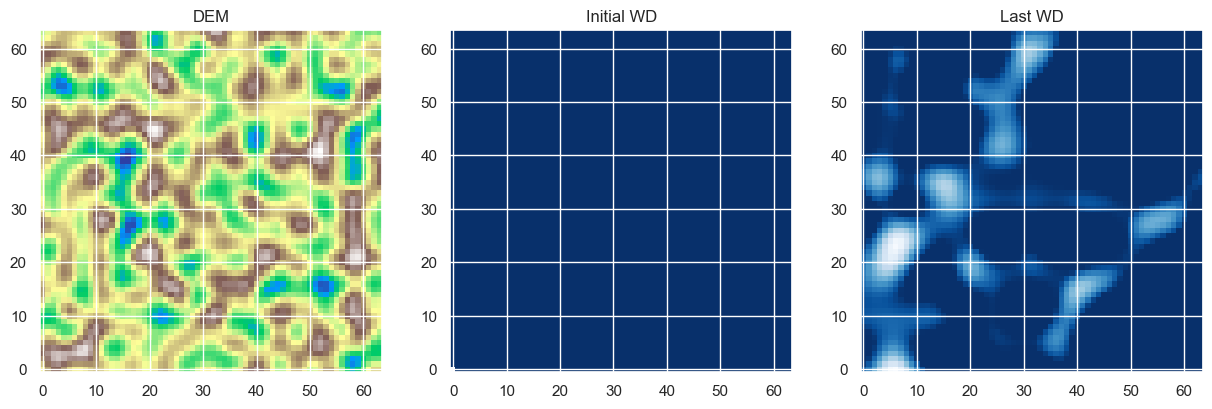

In [24]:
# Visualize Training Dataset 

number_grids = 64

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_dataset[19]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(train_dataset[0]['WD'][:,0].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('Initial WD')

axs[2].imshow(train_dataset[0]['WD'][:,-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[2].set_title('Last WD')
plt.show()

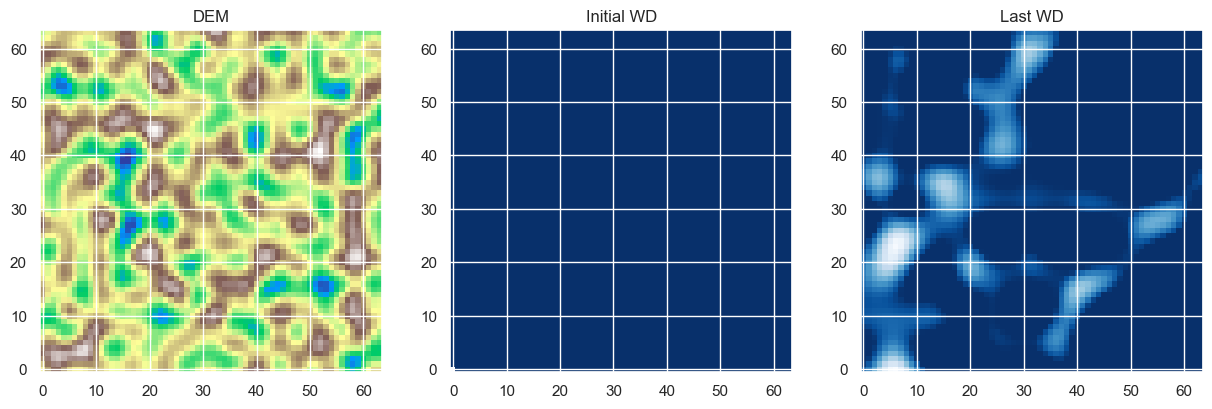

In [25]:
# Testing Dataset

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(test_dataset[19]['DEM'].reshape(number_grids,number_grids), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(test_dataset[0]['WD'][:,0].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('Initial WD')

axs[2].imshow(test_dataset[0]['WD'][:,-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[2].set_title('Last WD')
plt.show()

# Normalization

Since the input and output values may have very different ranges, it is important to perform normalization to both.

In [17]:
def normalize_dataset(dataset, scaler_DEM, scaler_WD):

    min_DEM, max_DEM = scaler_DEM.data_min_[0], scaler_DEM.data_max_[0]
    min_WD, max_WD = scaler_WD.data_min_[0], scaler_WD.data_max_[0]
    normalized_dataset = []

    for idx in range(len(dataset)):
        DEM = dataset[idx]['DEM']
        WD = dataset[idx]['WD']
        norm_DEM = (DEM - min_DEM) / (max_DEM - min_DEM)
        norm_WD = (WD - min_WD) / (max_WD - min_WD)

        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)


        DEM = norm_DEM.reshape(64,64)
        WD = norm_WD[:,0].reshape(64,64)

        temp_dict = {}
        temp_dict['Input'] = torch.stack((DEM, WD), dim=0)

        WD_transposed = norm_WD[:, 1:].reshape(64,64, -1)
        WD_transposed = WD_transposed.transpose(0, 2)
        WD_transposed = WD_transposed.transpose(1, 2)
        temp_dict['WD'] = WD_transposed

        normalized_dataset.append(temp_dict)

    return normalized_dataset

In [20]:
# Normalize the inputs and outputs using training dataset
scaler_DEM = MinMaxScaler() # Can store DEM, VX, VY as one 'input' Scaler
scaler_WD = MinMaxScaler()

for index in range(len(train_dataset)): # =80
    scaler_DEM.partial_fit(train_dataset[index]['DEM'].reshape(-1, 1).cpu())
    scaler_WD.partial_fit(train_dataset[index]['WD'].reshape(-1, 1).cpu())

normalized_train_dataset = normalize_dataset(train_dataset, scaler_DEM, scaler_WD)

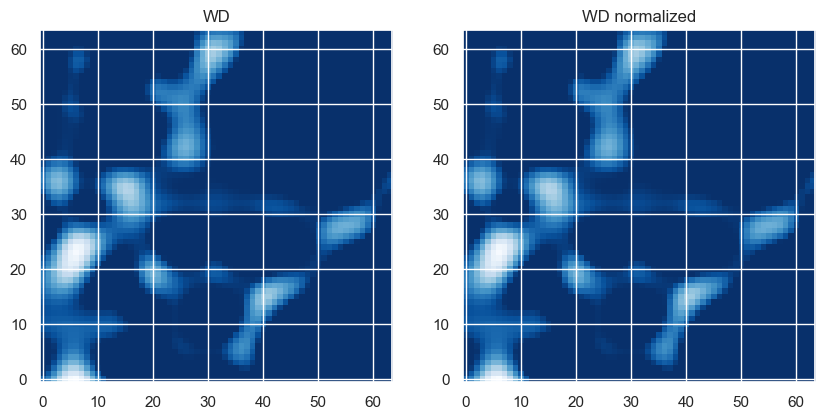

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(train_dataset[0]['WD'][:,-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[0].set_title('WD')

axs[1].imshow(normalized_train_dataset[0]['WD'][-1].reshape(number_grids,number_grids), cmap='Blues_r', origin='lower')
axs[1].set_title('WD normalized')
plt.show()

In [29]:
# Split dataset into train, validation, and testing
train_percnt = 0.8
train_size = int(train_percnt * len(train_dataset))
val_size = len(train_dataset) - train_size
training_dataset, val_dataset = random_split(normalized_train_dataset, [train_size, val_size])

In [40]:
# save normalized dataset to be easily used in the other notebooks

datatsets_folder = 'datasets/'
train_path = os.path.join(datasets_folder, "train.pkl")
val_path = os.path.join(datasets_folder, "validation.pkl")

with open(train_path, 'wb') as f:
    pickle.dump(training_dataset, f)
    
with open(val_path, 'wb') as f:
    pickle.dump(val_dataset, f)